In [158]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import seaborn as sns
import torch
sns.set(style='whitegrid')

random_seed = 42 # for reproductibility

In [159]:
## set cuda device

# Check if a CUDA GPU is available
if torch.cuda.is_available():
    # Set the default device to the first available GPU
    device = torch.device("cuda")
else:
    # If no GPU is available, use the CPU
    device = torch.device("cpu")

# You can print the device to verify it's set to CUDA
print("Using device:", device)


Using device: cpu


In [160]:
# Create a moon-shaped dataset with 100 samples
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)

# X contains the data points, and y contains their corresponding labels (0 or 1)

y

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,

In [161]:
## https://www.kaggle.com/code/charel/learn-by-example-expectation-maximization

In [162]:
def gaussian_2d(x, y, mean, cov):
    """
    Compute the value of a 2D Gaussian (bivariate normal) distribution at a given (x, y) point.

    Parameters:
    x (float): The x-coordinate.
    y (float): The y-coordinate.
    mean (array-like): The mean vector, [mean_x, mean_y].
    cov (2D array-like): The covariance matrix, [[var_x, cov_xy], [cov_xy, var_y]].

    Returns:
    float: The value of the 2D Gaussian PDF at point (x, y). [shape(x),shape(y)]
    """
    x_mean, y_mean = mean
    x_diff = x - x_mean
    y_diff = y - y_mean
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    exponent = np.exp(-0.5 * (x_diff * (cov_inv[0, 0] * x_diff + cov_inv[0, 1] * y_diff) +
                             y_diff * (cov_inv[1, 0] * x_diff + cov_inv[1, 1] * y_diff)))
    return (1.0 / (2 * np.pi * np.sqrt(cov_det))) * exponent



def expectation_maximization(data, n_components, max_iters=100, tol=1e-4):
    n_samples, _ = data.shape
    weights = np.ones((n_samples, n_components)) / n_components
    print("Shape of weights",weights.shape)
          
    means = data[np.random.choice(n_samples, n_components, replace=False)]
    covs = [np.cov(data.T)] * n_components

    for _ in range(max_iters):
        # E-step: Calculate responsibilities
        responsibilities = np.zeros((n_samples, n_components))
        for i in range(n_components):
            
            # print(weights[:, i].shape, gaussian_2d(data[:,0], data[:,1], means[i], covs[i]).shape)
            responsibilities[:, i] = weights[:, i] * gaussian_2d(data[:,0], data[:,1], means[i], covs[i])

        responsibilities /= responsibilities.sum(axis=1)[:, np.newaxis]

        # M-step: Update parameters
        new_weights = responsibilities.mean(axis=0)
        new_means = np.dot(responsibilities.T, data) / responsibilities.sum(axis=0)[:, np.newaxis]
        new_covs = [np.dot(responsibilities[:, i] * (data - new_means[i]).T, (data - new_means[i])) / responsibilities[:, i].sum() for i in range(n_components)]

        if np.allclose(new_weights, weights, atol=tol):
            break

        weights, means, covs = new_weights, new_means, new_covs

    return weights, means, covs

In [163]:
# print(data.shape,data[:,1].shape)

n_components = 1 # number of components
# Run the EM algorithm
weights, means, covs = expectation_maximization(X, n_components, max_iters=1000, tol=1e-5)


# print("Estimated Weights:", weights)
print("Estimated Means:", means)
print("Actual means:", np.mean(X,axis=0)) 
print("Estimated Covariances:", covs)

Shape of weights (1000, 1)
Estimated Means: [[2.033077  0.2097427]]
Actual means: [0.49850653 0.2473202 ]
Estimated Covariances: [array([[ 0.7609168 , -0.18907672],
       [-0.18907672,  0.25313676]])]


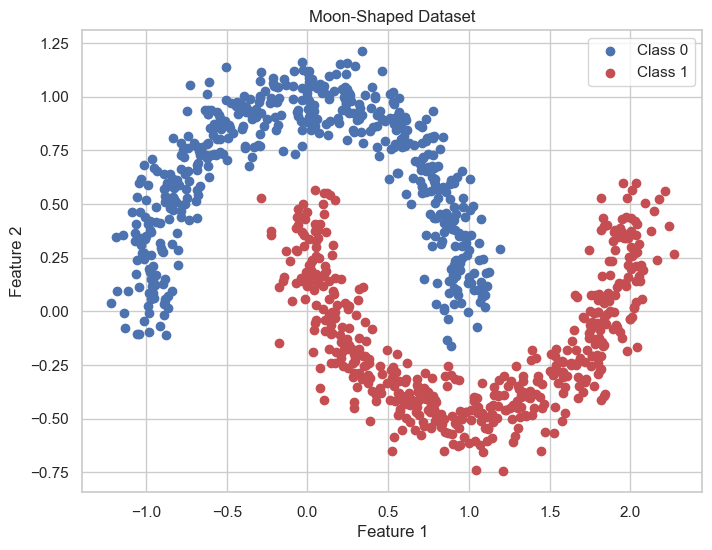

In [164]:
# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='Class 1')

plt.title("Moon-Shaped Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

plt.show()

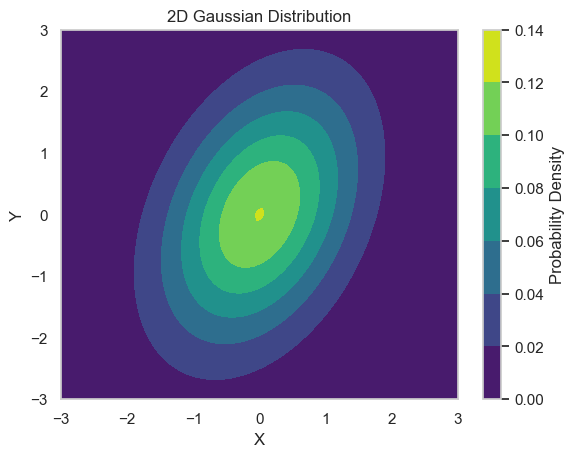

In [165]:
# # Parameters of the 2D Gaussian
mean = [0, 0]  # Mean vector [mean_x, mean_y]
cov = np.array([[1, 0.5], [0.5, 2]])  # Covariance matrix

# # Generate x and y values for plotting
x, y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

# # Evaluate the 2D Gaussian PDF at each (x, y) point
pdf = np.vectorize(gaussian_2d(x, y, mean, cov))


pdf = gaussian_2d(x,y, mean,cov)


# # Create a contour plot of the 2D Gaussian distribution
plt.contourf(x, y, pdf, cmap='viridis')
plt.colorbar(label='Probability Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Gaussian Distribution')
plt.grid()
plt.show()


In [166]:

print("jerer",means.tolist()[0])
print(covs)

x,y = np.meshgrid(X[:,0], X[:,1])

print(x.shape,y.shape)

pdf = gaussian_2d(x, y, means.tolist()[0], np.array(covs))

print(pdf.shape)

# # Create a contour plot of the 2D Gaussian distribution
plt.contourf(X, y, pdf, cmap='viridis')
plt.colorbar(label='Probability Density')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Gaussian Distribution')
plt.grid()
plt.show()


jerer [2.0330769970110385, 0.20974269817972907]
[array([[ 0.7609168 , -0.18907672],
       [-0.18907672,  0.25313676]])]
(1000, 1000) (1000, 1000)


ValueError: operands could not be broadcast together with shapes (2,) (1000,1000) 

In [ ]:
def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"

        source: https://www.onurtunali.com/ml/2019/03/08/maximum-mean-discrepancy-in-machine-learning.html
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)

    if kernel == 'squared_exp':
      bandwidth_range = [0.2, 0.5, 0.9, 1.3]
      for a in bandwidth_range:
        XX += torch.exp(-0.5 * dxx / (a**2))
        YY += torch.exp(-0.5 * dyy / (a**2))
        XY += torch.exp(-0.5 * dxy / (a**2))


    if kernel == "inverse_multi_quadratic":
      bandwidth_range = [0.2, 0.5, 0.9, 1.3]
      for a in bandwidth_range:
          XX += 1.0 / (1.0 + a**2 * dxx)
          YY += 1.0 / (1.0 + a**2 * dyy)
          XY += 1.0 / (1.0 + a**2 * dxy)




    return torch.mean(XX + YY - 2. * XY)

MMD result of X and Y is 0.448708713054657


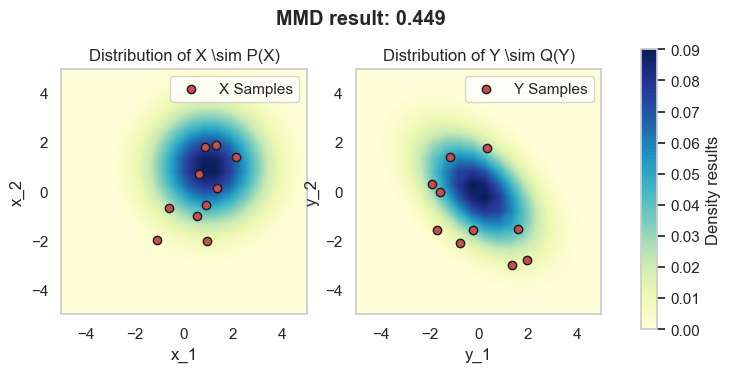

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet
from torch.distributions.multivariate_normal import MultivariateNormal


m = 20 # sample size
x_mean = torch.zeros(2)+1
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3*torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(y_mean, y_cov)
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")

# ---- Plotting setup ----

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=100)
#plt.tight_layout()
delta = 0.025

x1_val = np.linspace(-5, 5, num=m)
x2_val = np.linspace(-5, 5, num=m)

x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = torch.zeros(m,m)
qy_grid = torch.zeros(m,m)


for i in range(m):
    for j in range(m):
        px_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], x_mean, x_cov)
        qy_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], y_mean, y_cov)


CS1 = ax1.contourf(x1, x2, px_grid,100, cmap=plt.cm.YlGnBu)
ax1.set_title("Distribution of X \sim P(X)")
ax1.set_ylabel('x_2')
ax1.set_xlabel('x_1')
ax1.set_aspect('equal')
ax1.scatter(x[:10,0].cpu(), x[:10,1].cpu(), label="X Samples", marker="o", facecolor="r", edgecolor="k")
ax1.legend()

CS2 = ax2.contourf(x1, x2, qy_grid,100, cmap=plt.cm.YlGnBu)
ax2.set_title("Distribution of Y \sim Q(Y)")
ax2.set_xlabel('y_1')
ax2.set_ylabel('y_2')
ax2.set_aspect('equal')
ax2.scatter(y[:10,0].cpu(), y[:10,1].cpu(), label="Y Samples", marker="o", facecolor="r", edgecolor="k")
ax2.legend()
#ax1.axis([-2.5, 2.5, -2.5, 2.5])

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS2, cax=cbar_ax)
cbar.ax.set_ylabel('Density results')
plt.suptitle(f"MMD result: {round(result.item(),3)}",y=0.95, fontweight="bold")
plt.show()
